In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from wgomoku import GomokuTools as gt, SampleDataHelper

In [4]:
import numpy as np
import tensorflow as tf

In [5]:
def new_dataset(file_pattern, gamma, sdh,
                batch_size=256, num_epochs=1, buffer_size=500):
    
    games = tf.data.experimental.make_csv_dataset(
        file_pattern = file_pattern,
        column_names=["game", "winner"],
        batch_size=1,
        num_epochs=num_epochs
    ) 
    def _generator(): 
        for batch in iter(games):
            game = batch['game'][0].numpy().decode('ascii')
            smp, lbl = sdh.from_string_with_bellmann(game, -1, gamma)
            zipped = zip(smp, lbl)
            for s_and_v in zipped:
                yield s_and_v
    
    inputs = tf.data.Dataset.from_generator(
        _generator, output_types=(tf.int32, tf.float32))
    
    inputs = inputs.shuffle(buffer_size).batch(batch_size)
    return inputs
    

In [9]:
N=19
sdh = SampleDataHelper(N, representation='NxNx1B')
inputs = new_dataset(file_pattern="*first3.csv", gamma=.9, sdh=sdh, batch_size=1)

In [10]:
smp, lbl = next(iter(inputs))

In [11]:
smp.shape, lbl.shape

(TensorShape([1, 21, 21, 2]), TensorShape([1]))

---
### The model

In [12]:
def disp(sample):
    if tf.is_tensor(sample):
        sample = sample.numpy()
    s = np.rollaxis(sample, -1, 0)
    return str(s[0]+2*s[1])

In [13]:
class GomokuModelFactory:
    
    def __init__(self, board_size=19):
        self.board_size=board_size
    
    def res_block(self, inp, filters, activation='relu'):

        out1_3 = tf.keras.layers.Conv2D(kernel_size=3, filters=filters, 
                                  padding='same', activation=activation)(inp)
        out1_5 = tf.keras.layers.Conv2D(kernel_size=5, filters=filters,
                                  padding='same', activation=activation)(inp)
        out1 = tf.concat([out1_3, out1_5], axis=3)

        out2_3 = tf.keras.layers.Conv2D(kernel_size=3, filters=filters,
                                  padding='same', activation=activation)(out1)
        out2_5 = tf.keras.layers.Conv2D(kernel_size=5, filters=filters,
                                  padding='same', activation=activation)(out1)
        out2 = tf.concat([out2_3, out2_5], axis=3)

        out3_3 = tf.keras.layers.Conv2D(kernel_size=3, filters=filters, 
                                  padding='same', activation=activation)(out2)
        out3_5 = tf.keras.layers.Conv2D(kernel_size=5, filters=filters, 
                                  padding='same', activation=activation)(out2)
        out3 = tf.concat([out3_3, out3_5], axis=3)

        skip = tf.keras.layers.Conv2D(kernel_size=1, filters=2,
                                padding='same', activation=None)(inp)

        concat = tf.concat([skip, out3], axis=3)   

        bn = tf.keras.layers.BatchNormalization()(concat)

        return bn
    
    
    def create_value_model(self, name, num_blocks, num_filters, optimizer):

        inputs = tf.keras.Input(
            shape=[self.board_size+2,self.board_size+2,2], name="game_samples")
        
        labels = tf.keras.Input(
            shape=[1,1,1], name="value_labels")
        
        block = self.res_block(inputs, num_filters)
        for i in range(num_blocks):
            block = self.res_block(block, num_filters)
        
        out = tf.keras.layers.Conv2D(kernel_size=1, filters=1,
                       padding='same', activation='tanh')(block)
        
        flat = tf.keras.layers.Flatten()(out)
        hidden1 = tf.keras.layers.Dense(units=256)(flat)
        hidden2 = tf.keras.layers.Dense(units=64)(hidden1)
        value_head = tf.keras.layers.Dense(units=1, activation='tanh')(hidden2)
        #value_head = tf.keras.layers.MaxPool2D(pool_size=self.board_size)(out)        
        
        model = tf.keras.Model(inputs, value_head)

        model.compile(optimizer, loss='mean_squared_error')
        
        return model


In [14]:
factory = GomokuModelFactory(board_size=19)

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3)

In [16]:
value_model = factory.create_value_model("Value_Net", 10, 32, optimizer)

In [17]:
sdh = SampleDataHelper(N=19, representation='NxNx1B', cut_off=12)
inputs = new_dataset(batch_size=512, num_epochs=5, sdh=sdh,
                     buffer_size=500, file_pattern = "*corr.csv", gamma=0.5)

W0802 19:45:23.157383 140539147208448 deprecation.py:323] From /home/wgiersche/workspace/DeepGomoku/tf2/lib/python3.5/site-packages/tensorflow/python/data/experimental/ops/readers.py:211: shuffle_and_repeat (from tensorflow.python.data.experimental.ops.shuffle_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [19]:
value_model.fit(inputs)

In [21]:
checkpoint_path = './models/ValueNet_2.0/cp-{epoch:04d}.ckpt'

In [20]:
value_model.save_weights(checkpoint_path.format(epoch=5))

In [23]:
latest = tf.train.latest_checkpoint("./models/ValueNet_2.0/")
latest

'./models/ValueNet_2.0/cp-0005.ckpt'

In [24]:
new_model = factory.create_value_model("Value_Net", 10, 32, optimizer)
new_model.load_weights(latest)

---
Let's see the result with the help of an example

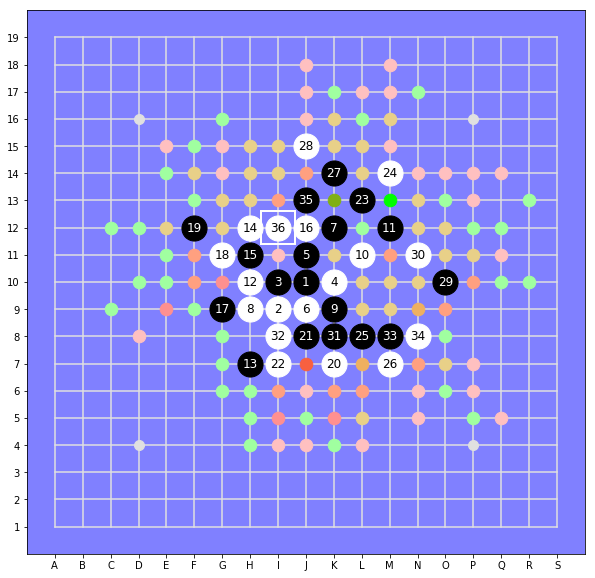

In [25]:
from wgomoku import HeuristicGomokuPolicy, GomokuBoard, Heuristics
heuristics = Heuristics(kappa=3.0)
game="j10i9i10k10j11j9k12h9k9l11m12h10h7h12h11j12g9g11f12k7j8i7l13m14l8m7k14j15o10n11k8i8m8n8j13i12k13m13k15k16k11"
game="j10i9i10k10j11j9k12h9k9l11m12h10h7h12h11j12g9g11f12k7j8i7l13m14l8m7k14j15o10n11k8i8m8n8j13i12"

stones=gt.string_to_stones(game)
board = GomokuBoard(N=19, stones=stones, disp_width=10, heuristics=heuristics)
board.display('current')

Let's have a look at the numerical representation: The next to move would be player (1)

In [26]:
coords = sdh.maybe_padded_coords(game+"")
samples, values = sdh.traj_to_samples(traj=coords, gamma=0.5, terminal_value=-1)
smp = samples[-1]
print(disp(smp))

[[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  1  0 -1  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  1  0 -1 -1 -1  1  0  1  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0 -1  1  0  1  0 -1  0 -1  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0 -1  1  1 -1  0  0  0  1  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  1 -1 -1 -1  1  0  0  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0 -1  1  1  1  1 -1  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  1 -1  0 -1  0 -1  0  0  0  0  0  0  2]
 [ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2]
 [ 2  0  0

In [27]:
value_model.predict(smp.reshape(1,21,21,2))

array([[-0.48075557]], dtype=float32)

In [28]:
new_model.predict(smp.reshape(1,21,21,2))

array([[0.1896637]], dtype=float32)